# Model 9

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

In [1]:
!ln -s ../data/ ./
!ln -s ../out/ ./

In [3]:
import os

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import itertools
from pylab import rcParams
import matplotlib

import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
from numpy import genfromtxt
import tensorflow as tf
import keras
from keras.layers import Activation, Dense

from tensorflow.contrib import learn
from sklearn import cross_validation
from sklearn import preprocessing
from sklearn import metrics


%matplotlib inline

np.random.seed(1) # set a seed so that the results are consistent

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load data for train

In [4]:
train = pd.read_csv('data/Train_data/dataset_rev4_train.csv')
#buffer datetime
buffer_datetime_train = train.datetime
#remove object
train = train.select_dtypes(exclude=['object'])
#replace misssing value
train.fillna(0,inplace=True)

# Load data for test

In [5]:
test = pd.read_csv('data/test_data/dataset_rev4_test.csv')
#buffer datetime
buffer_datetime_test = test.datetime
#remove object
test = test.select_dtypes(exclude=['object'])
#replace misssing value
test.fillna(0,inplace=True)

In [6]:
print('dimension of train:', train.shape)
print('dimension of test:', test.shape)

dimension of train: (131586, 6)
dimension of test: (16147, 5)


In [7]:
print("features:",list(train.columns))

features: ['I', 'T', 'UV', 'WS', 'RH', 'P']


# Remove outlier

In [8]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train)
y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train.shape[0])

Number of Outliers: 13159
Number of rows without outliers: 118427


# Normalize

In [9]:
import warnings
warnings.filterwarnings('ignore')

col_train = list(train.columns)
col_train_bis = list(train.columns)

col_train_bis.remove('P')

mat_train = np.matrix(train)
mat_test  = np.matrix(test)

mat_new = np.matrix(train.drop('P',axis = 1))
mat_y = np.array(train.P).reshape((118427,1))

prepro_y = MinMaxScaler()
prepro_y.fit(mat_y)

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

train = pd.DataFrame(prepro.transform(mat_train),columns = col_train)
test  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)

# Create training_set and prediction_set

In [10]:
# List of features
COLUMNS = col_train #column train (x train)
FEATURES = col_train_bis  #column train-label (x test)
LABEL = "P"

# Columns
feature_cols = FEATURES #(x test)

# Training set and Prediction set with the features to predict
training_set = train[COLUMNS] #column train (x train)
prediction_set = train.P # column P

In [11]:
print(type(training_set))
print(type(prediction_set))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


# Create x_train and Test

In [12]:
x_train, x_test, y_train, y_test = train_test_split(training_set[FEATURES] , prediction_set, test_size=0.33, random_state=42)

In [13]:
print(type(x_train))
print(type(x_test))
print(type(y_train))
print(type(y_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [14]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(79346, 5)
(39081, 5)
(79346,)
(39081,)


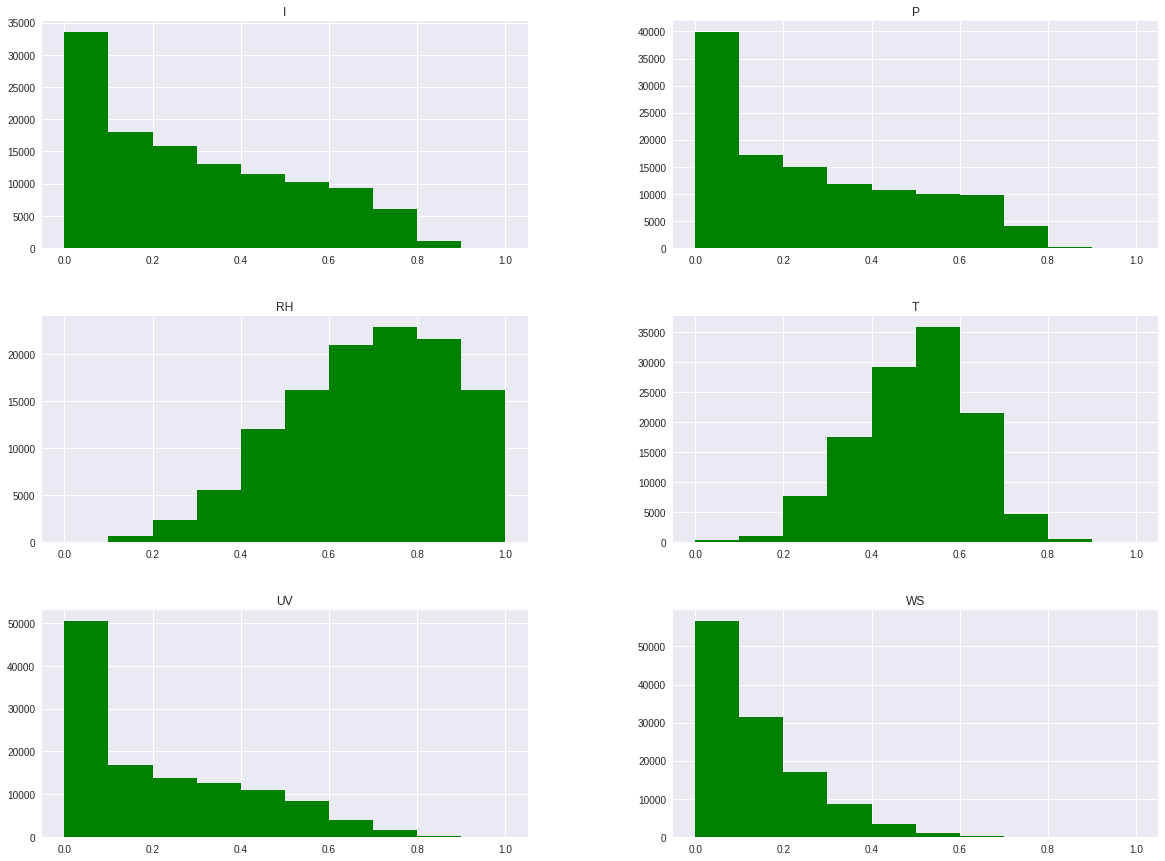

In [15]:
train.hist(figsize=(20,15), color = 'green')
plt.show()

# Check for NULL values

In [16]:
print('Let\'s check for null values\n')
print(train.isnull().sum())

Let's check for null values

I     0
T     0
UV    0
WS    0
RH    0
P     0
dtype: int64


# Droping NaN value

In [17]:
x_train = x_train.dropna(axis=0)
print("\nNew Shape after dropping NULL value : ", x_train.shape)
x_test = x_test.dropna(axis=0)
print("\nNew Shape after dropping NULL value : ", x_test.shape)
y_train = y_train.dropna(axis=0)
print("\nNew Shape after dropping NULL value : ", y_train.shape)
y_test = y_test.dropna(axis=0)
print("\nNew Shape after dropping NULL value : ", y_test.shape)


New Shape after dropping NULL value :  (79346, 5)

New Shape after dropping NULL value :  (39081, 5)

New Shape after dropping NULL value :  (79346,)

New Shape after dropping NULL value :  (39081,)


In [18]:
print('Let\'s check for null values\n')
print(x_train.isnull().sum())

print('Let\'s check for null values\n')
print(x_test.isnull().sum())

print('Let\'s check for null values\n')
print(y_train.isnull().sum())

print('Let\'s check for null values\n')
print(y_test.isnull().sum())

Let's check for null values

I     0
T     0
UV    0
WS    0
RH    0
dtype: int64
Let's check for null values

I     0
T     0
UV    0
WS    0
RH    0
dtype: int64
Let's check for null values

0
Let's check for null values

0


# Creating Feature Columns in TensorFlow

In [19]:
training_set.columns

Index(['I', 'T', 'UV', 'WS', 'RH', 'P'], dtype='object')

In [20]:
I = tf.feature_column.numeric_column('I')
T = tf.feature_column.numeric_column('T')
UV = tf.feature_column.numeric_column('UV')
WS = tf.feature_column.numeric_column('WS')
RH = tf.feature_column.numeric_column('RH')

# Aggregating the feature columns

In [21]:
feat_cols = [I, T, UV, WS, RH]

In [22]:
feat_cols

[_NumericColumn(key='I', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='T', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='UV', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='WS', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='RH', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

# Creating input

In [23]:
input_func = tf.estimator.inputs.pandas_input_fn(x = x_train, y = y_train, batch_size = 20, num_epochs = 2000, shuffle = True)

In [24]:
model = tf.estimator.DNNRegressor(hidden_units = [8, 8, 8, 8, 8], feature_columns = feat_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpyy8hq3om', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff018640048>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


# Training model for 50000 steps

In [25]:
model.train(input_fn = input_func, steps = 50000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpyy8hq3om/model.ckpt.
INFO:tensorflow:loss = 3.0937333, step = 1
INFO:tensorflow:global_step/sec: 385.129
INFO:tensorflow:loss = 0.08780523, step = 101 (0.265 sec)
INFO:tensorflow:global_step/sec: 423.11
INFO:tensorflow:loss = 0.1515698, step = 201 (0.236 sec)
INFO:tensorflow:global_step/sec: 433.209
INFO:tensorflow:loss = 0.04070045, step = 301 (0.233 sec)
INFO:tensorflow:global_step/sec: 431.626
INFO:tensorflow:loss = 0.057928093, step = 401 (0.234 sec)
INFO:tensorflow:global_step/sec: 428.356
INFO:tensorflow:loss = 0.07216892, step = 501 (0.228 sec)
INFO:tensorflow:global_step/sec: 430.767
INFO:tensorflow:loss = 0.09581885, step = 601 (0.240 sec)
INFO:tensorflow:global_step/sec: 433.793
INFO:tensor

# Predicting the value

In [26]:
predict_input_func = tf.estimator.inputs.pandas_input_fn(x = x_test, batch_size = 20, num_epochs = 1, shuffle = False)

In [27]:
pred_gen = model.predict(predict_input_func)

In [28]:
predictions = list(pred_gen)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpyy8hq3om/model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [30]:
predictions

[{'predictions': array([0.3749581], dtype=float32)},
 {'predictions': array([0.6748589], dtype=float32)},
 {'predictions': array([0.5881988], dtype=float32)},
 {'predictions': array([0.02217529], dtype=float32)},
 {'predictions': array([0.11001506], dtype=float32)},
 {'predictions': array([0.23359555], dtype=float32)},
 {'predictions': array([0.319331], dtype=float32)},
 {'predictions': array([0.4965683], dtype=float32)},
 {'predictions': array([0.4224232], dtype=float32)},
 {'predictions': array([0.4634163], dtype=float32)},
 {'predictions': array([0.48247132], dtype=float32)},
 {'predictions': array([0.66265464], dtype=float32)},
 {'predictions': array([0.21584898], dtype=float32)},
 {'predictions': array([0.323757], dtype=float32)},
 {'predictions': array([0.00245735], dtype=float32)},
 {'predictions': array([0.03995782], dtype=float32)},
 {'predictions': array([0.0562306], dtype=float32)},
 {'predictions': array([0.21783392], dtype=float32)},
 {'predictions': array([0.01562445], dt

In [31]:
final_y_preds = []

for pred in predictions:
    final_y_preds.append(pred['predictions'])

In [32]:
final_y_preds

[array([0.3749581], dtype=float32),
 array([0.6748589], dtype=float32),
 array([0.5881988], dtype=float32),
 array([0.02217529], dtype=float32),
 array([0.11001506], dtype=float32),
 array([0.23359555], dtype=float32),
 array([0.319331], dtype=float32),
 array([0.4965683], dtype=float32),
 array([0.4224232], dtype=float32),
 array([0.4634163], dtype=float32),
 array([0.48247132], dtype=float32),
 array([0.66265464], dtype=float32),
 array([0.21584898], dtype=float32),
 array([0.323757], dtype=float32),
 array([0.00245735], dtype=float32),
 array([0.03995782], dtype=float32),
 array([0.0562306], dtype=float32),
 array([0.21783392], dtype=float32),
 array([0.01562445], dtype=float32),
 array([0.13037549], dtype=float32),
 array([0.6213587], dtype=float32),
 array([0.18717702], dtype=float32),
 array([0.2176358], dtype=float32),
 array([0.3418233], dtype=float32),
 array([0.01628408], dtype=float32),
 array([0.00281934], dtype=float32),
 array([0.14542891], dtype=float32),
 array([0.47815

# # Fianl RMSE Value using DNN Regressor

In [33]:
mean_squared_error(y_test, final_y_preds) ** 0.5

0.06045082800931639

#  RSME VALUE USING DNN REGRESSOR  = 72474.108532716637
            -> I have used Neural Net with 4 hidden layers, each having 8 input values 
            -> Model trained using batch_size = 20, num_epochs = 2000 and Steps = 50,000

# Working on Sklearn Models

# Random Forest Regressor

In [34]:
# Training Model
rf_regressor = RandomForestRegressor(n_estimators=500, random_state = 0)
rf_regressor.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [35]:
# Predicting the values
y_pred = rf_regressor.predict(x_test)

In [36]:
p = mean_squared_error(y_test, y_pred)
print(p ** 0.5)

0.0567373713906699


 RSME VALUE USING 
            -> Random Forest Regressor using 500 estimators =  49775.266747